In [1]:
#@title Configuration
from google.colab import drive
import os
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"


Mounted at /content/drive


In [2]:
#@title Initialization { display-mode: "both" }
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

In [21]:
#@title Common Imports
from pyspark import SparkContext, SparkConf
import sys
import json
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate()
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import widgets
from IPython.display import display
from math import sqrt
from os.path import exists

from pyspark.ml.stat import Correlation
from pyspark.sql.functions import covar_pop

File path, Folder ID, Constants and other related information

In [4]:
#@title File path, Folder ID, Constants
drivepath = "/content/drive/Shareddrives/ProjectSharedDrive/wazirxCSVData"
driveDAILYpath = "/content/drive/Shareddrives/ProjectSharedDrive/wazirxCSVCumulative"
cryptofile = "/content/drive/Shareddrives/ProjectSharedDrive/top25_cryptocoins_list.jsonl"


In [6]:
#@title Load Coin names and TOP-10 List
fileRef = open(driveDAILYpath+"/USDTCoinName.txt" ,"r")
coinName = []
coinCode = []
for lines in fileRef:
  name = eval(lines[:-1])
  coinName.append(name[1])
  coinCode.append(name)


_crypt_raw = spark.read.json(cryptofile)
_crypt = _crypt_raw.withColumn("name", F.col("name")) \
          .withColumn("symbol", F.col("symbol")) \
          .withColumn("cmc_rank", F.col("cmc_rank")).orderBy("cmc_rank")
#_crypt.show()
top10=[]
j=0
for i in _crypt.collect():
   top10.append(i[1])
   j+=1
   if(j==10):
     break

coinNameW10 = [x for x in coinName if x not in top10]

## **Interactive Display for Correlation Analysis**

Choose the coin to start processing

In [7]:
#@title Select the Coin

coin = widgets.Dropdown(
    options=coinNameW10,
    value=coinNameW10[0],
    description='Select Coin: ',
    disabled=False,
)

display(coin)


Dropdown(description='Select Coin: ', options=('TRON', 'EOS', 'ICON', 'Litecoin', 'TrueUSD', 'Hydro Protocol',…

Processing the selected coin. Run the next columns for output

In [9]:
#@title Performing Correlation Analysis with Top-10 Coins

coinChosen = [item for item in coinCode if item[1] == coin.value]
coinname = coin.value
print(coinname)
coinfile = driveDAILYpath+"/"+coinChosen[0][0]+"DAILY.csv"


p0 = spark.read.option("header",True).option("inferSchema",True).csv(coinfile)
p2 = p0.drop("_c0").drop("Open").drop("High").drop("Close").drop("Low")


corr = []

for i in top10:
  coinChosen = [item for item in coinCode if item[1] == i]
  coinname = i
    # print(coinname)
  coinfile = driveDAILYpath+"/"+coinChosen[0][0]+"DAILY.csv"
  #print(coinfile)
  #coinn = "coindf"+i
  coinn = spark.read.option("header",True).option("inferSchema",True).csv(coinfile)
  topcoindf = coinn.drop("_c0").drop("Open").drop("High").drop("Close").drop("Low").withColumnRenamed("Volume","top_vol").withColumnRenamed("Date","top_date")
  #topcoin.show()
  
  joindf = p2.join(topcoindf,(p2.Date==topcoindf.top_date)).drop("Date").drop("top_date")
  
  corr.append(joindf.corr("Volume","top_vol"))

DigiByte


## **Visualization** 




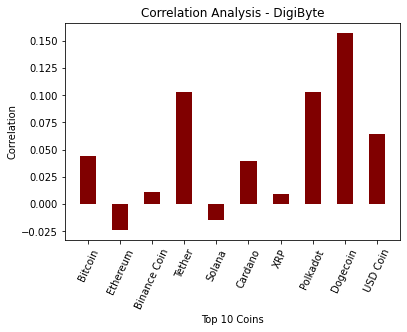

In [12]:
#@title Create the Graph
plt.xlabel("Top 10 Coins")

plt.bar(top10, corr, color ='maroon',width = 0.5)
plt.xticks(rotation=65)


#print(xval)
#f = plt.figure()
#f.set_figwidth(200)
#f.set_figheight(100)
#plt.xlabel(Freq)
plt.ylabel("Correlation")
#plt.legend(loc="upper right")
plt.title("Correlation Analysis - "+ coin.value)
plt.rcParams["figure.figsize"] = (5,10)


#plt.xticks(xval[::200])
plt.show()

## **Interactive Display for Covariance of two coins**




In [17]:
#@title Select the Coin 1

coin1 = widgets.Dropdown(
    options=coinName,
    value=coinName[0],
    description='Select Coin: ',
    disabled=False,
)

display(coin1)


Dropdown(description='Select Coin: ', options=('Tether', 'Bitcoin', 'TRON', 'XRP', 'EOS', 'Ethereum', 'ICON', …

In [18]:
#@title Select the Coin 2

coin2 = widgets.Dropdown(
    options=coinName,
    value=coinName[0],
    description='Select Coin: ',
    disabled=False,
)

display(coin2)


Dropdown(description='Select Coin: ', options=('Tether', 'Bitcoin', 'TRON', 'XRP', 'EOS', 'Ethereum', 'ICON', …

In [22]:
#@title Covariance Logic

def calcCovariance(coinname1, coinname2):
  coinfile1 = "/content/drive/Shareddrives/ProjectSharedDrive/wazirxCSVCumulative"+"/"+coinname1+".csv"
  coinfile2 = "/content/drive/Shareddrives/ProjectSharedDrive/wazirxCSVCumulative"+"/"+coinname2+".csv"

  if exists(coinfile1) == False:
    print("File not found:", coinname1)
    return

  if exists(coinfile2) == False:
    print("File not found:", coinname2)
    return

  hfile1 = sc.textFile(coinfile1)
  hfile2 = sc.textFile(coinfile2)
  

  # Convert to Key-Value RDD with Date: Closing Price Columns 
  coinRDD1 = hfile1.map(lambda l: l.split(",")).map(lambda l: (l[1], l[5])).filter(lambda kv : kv[0] != "Date").map(lambda l: (l[0], float(l[1])))  # remove header row
  coinRDD2 = hfile2.map(lambda l: l.split(",")).map(lambda l: (l[1], l[5])).filter(lambda kv : kv[0] != "Date").map(lambda l: (l[0], float(l[1])))  # remove header row
  
  jRDD = coinRDD1.join(coinRDD2)


  mapRDD1 = jRDD.map(lambda l: (coinname1, l[1][0]))
  aggRDD1 = mapRDD1.aggregateByKey((0,0), lambda a,b: (a[0] + b,    a[1] + 1),
                                    lambda a,b: (a[0] + b[0], a[1] + b[1]))
  # Calculate mean and store it in meanRdd
  meanVal1 = aggRDD1.mapValues(lambda v: v[0]/v[1]).sortBy(lambda l: l[0]).map(lambda l: l[1]).collect()


  mapRDD2 = jRDD.map(lambda l: (coinname2, l[1][1]))
  aggRDD2 = mapRDD2.aggregateByKey((0,0), lambda a,b: (a[0] + b,    a[1] + 1),
                                    lambda a,b: (a[0] + b[0], a[1] + b[1]))
  # Calculate mean and store it in meanRdd
  meanVal2 = aggRDD2.mapValues(lambda v: v[0]/v[1]).sortBy(lambda l: l[0]).map(lambda l: l[1]).collect()


  jmapRDD = jRDD.map(lambda l: (l[0], l[1][0], meanVal1[0], l[1][1], meanVal2[0])).map(lambda l: (l[0], l[1]-l[2], l[3]-l[4])).map(lambda l: (l[0], l[1]*l[2])).map(lambda l: ("key", l[1]))

  jmeanVal = jmapRDD.aggregateByKey((0,0), lambda a,b: (a[0] + b,    a[1] + 1),
                                    lambda a,b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda v: v[0]/v[1]).sortBy(lambda l: l[0]).map(lambda l: l[1]).collect()
  answer = jmeanVal[0]


  return answer

In [24]:
#@title Display the Covariance

coinChosen1 = [item for item in coinCode if item[1] == coin1.value]
coinChosen2 = [item for item in coinCode if item[1] == coin2.value]

calcCovariance(coinChosen1[0][0]+"DAILY", coinChosen2[0][0]+"DAILY")

25723.345813302516